In [2]:
import numpy as np
%matplotlib inline
import glob
import re
import os

import Corrfunc
import nbodykit
from nbodykit.lab import *

import utils
import plotter
import bao_utils

%load_ext autoreload
%autoreload 2

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
textsize = 'x-large'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'xtick.labelsize': textsize,
         'ytick.labelsize': textsize}
pylab.rcParams.update(params)

In [3]:
ctopmany = '#1A85FF'
ctopfew = '#61FFF9'
cspline = '#F55B94'
cbao = '#18CE30'

In [4]:
def plot_cf_err(rs, cf_arrs, r_true, cf_true, labels, colors, err=False, errlim=None, xlim=None):
    
    if np.array(rs).ndim == 1:
        rs = [rs]
    if np.array(cf_arrs).ndim == 2:
        cf_arrs = np.array([cf_arrs])
    
    cfs_mean = []
    error_regions = []
    for cfs in cf_arrs:
        mean = np.mean(cfs, axis=0)
        cfs_mean.append(mean)
        std = np.std(cfs, axis=0)
        error_regions.append([mean-std, mean+std])
    
    plotter.plot_cf_cont(rs, cfs_mean, r_true, cf_true, labels, colors, error_regions=error_regions, 
                         err=err, errlim=errlim, xlim=xlim)

In [5]:
def plot_continuous(cat_tag, cf_tags, realizations=range(100), colors=None, labels=None, err=False, errlim=None):
    
    if colors is None:
        colors = ['lime','blue', 'cyan', 'magenta', 'purple']
    if labels is None:
        labels = [f"{tag.split('_')[1]}, bin width {tag.split('bw')[-1]}" for tag in cf_tags]

    cat_dir = '../catalogs'
    result_dir = '../results/results_lognormal{}'.format(cat_tag)

    rs = []
    cf_arrs = []

    for i in range(len(cf_tags)):
        xis = []
        for Nr in realizations:
            cf_fn = '{}/cf{}{}_rlz{}.npy'.format(result_dir, cf_tags[i], cat_tag, Nr)
            r_avg, xi, amps, _, _ = np.load(cf_fn, allow_pickle=True)
            #print("C:", amps[4])
            print(amps)
            xis.append(xi)
        rs.append(r_avg)
        cf_arrs.append(xis)     

    # true
    true_fn = '{}/inputs/cat{}_Rh_xi.txt'.format(cat_dir, cat_tag)
    r_true, xi_true = np.loadtxt(true_fn, unpack=True)
    b1 = 1.5    
    xi_true *= b1**2

    #print(np.array(cf_arrs).shape)
    #print(xi_true.shape)
    plot_cf_err(rs, cf_arrs, r_true, xi_true, labels, colors, err=err, errlim=errlim)

    plt.xlim(min(r_avg), max(r_avg))
    plt.ylim(min(np.array(xis).flatten()), max(xi))

In [6]:
def plot_baoiter_converged(cat_tag, cf_tags, realizations=range(100), colors=None, labels=None, err=True, errlim=None):
    
    if colors is None:
        colors = ['lime','blue', 'cyan', 'magenta', 'purple']
    if labels is None:
        labels = [f"{tag.split('_')[1]}, bin width {tag.split('bw')[-1]}" for tag in cf_tags]

    cat_dir = '../catalogs'
    result_dir = '../results/results_lognormal{}'.format(cat_tag)

    rs = []
    cf_arrs = []

    
    for i in range(len(cf_tags)):
        xis = []
        n_converged = 0
        for Nr in realizations:
            
            if 'baoiter' in cf_tags[i]:
                fn_pattern = f"cf{cf_tags[i]}_converged_*{cat_tag}_rlz{Nr}.npy"
                for cf_fn in glob.glob(f'{result_dir}/{fn_pattern}'):
                    #print(cf_fn)
                    r_avg, xi, amps, _, _ = np.load(cf_fn, allow_pickle=True)
                    #print("C:", amps[4])
                    n_converged +=1
                    break #should only be 1 match; but probs better way to do this
            else:
                cf_fn = '{}/cf{}{}_rlz{}.npy'.format(result_dir, cf_tags[i], cat_tag, Nr)
                r_avg, xi, amps = np.load(cf_fn, allow_pickle=True)
                
            xis.append(xi)
        if 'baoiter' in cf_tags[i]:
            print(f"Found {n_converged} converged BAO cfs ({len(realizations)-n_converged} not converged)")
        rs.append(r_avg)
        cf_arrs.append(xis)     

    # true
    true_fn = '{}/inputs/cat{}_Rh_xi.txt'.format(cat_dir, cat_tag)
    r_true, xi_true = np.loadtxt(true_fn, unpack=True)
    b1 = 1.5    
    xi_true *= b1**2

    #print(np.array(cf_arrs).shape)
    #print(xi_true.shape)
    xlim = [min(np.array(rs).flatten()), 148]
    plot_cf_err(rs, cf_arrs, r_true, xi_true, labels, colors, err=err, errlim=errlim, xlim=xlim)

    #plt.xlim(min(np.array(rs).flatten()), min([max(r_arr) for r_arr in np.array(rs)]))
    #plt.ylim(min(np.array(xis).flatten()), max(xi))

In [14]:
def calc_alpha(cat_tag, cf_tag, realizations=range(100)):
    cat_dir = '../catalogs'
    result_dir = '../results/results_lognormal{}'.format(cat_tag)
    
    xis = []
    n_converged = 0
    alphas = []
    for Nr in realizations:

        if 'baoiter' in cf_tag:
            fn_pattern = f"cf{cf_tag}_converged_*{cat_tag}_rlz{Nr}.npy"
            for cf_fn in glob.glob(f'{result_dir}/{fn_pattern}'):
                #print(cf_fn)
                r_avg, xi, amps, _, extra_dict = np.load(cf_fn, allow_pickle=True)
                #print("C:", amps[4])
                alphas.append(extra_dict ['alpha_result'])
                n_converged +=1
                break #should only be 1 match; but probs better way to do this
        else:
            cf_fn = '{}/cf{}{}_rlz{}.npy'.format(result_dir, cf_tags[i], cat_tag, Nr)
            r_avg, xi, amps = np.load(cf_fn, allow_pickle=True)

    print(cf_tag)
    print(f"Found {n_converged} converged BAO cfs ({len(realizations)-n_converged} not converged)")    
    print("alpha_mean:", np.mean(alphas))
    print("alpha_std:", np.std(alphas))

In [12]:
cat_tag = '_L750_n3e-5'
cf_tag = '_baoiter_alpha1.1'
calc_alpha(cat_tag, cf_tag)

_baoiter_alpha1.1
alpha_mean: 1.0240607303757203
alpha_std: 0.1076636844219285


In [10]:
cat_tag = '_L750_n1e-4'
cf_tag = '_baoiter_alpha1.1'
calc_alpha(cat_tag, cf_tag)

_baoiter_alpha1.1
alpha_mean: 0.9892690766889218
alpha_std: 0.058031142120067915


In [11]:
cat_tag = '_L750_n3e-4'
cf_tag = '_baoiter_alpha1.1'
calc_alpha(cat_tag, cf_tag)

_baoiter_alpha1.1
alpha_mean: 0.9954431983301081
alpha_std: 0.03703841266054042


Found 100 converged BAO cfs (0 not converged)
(2, 1000)
rmse: True
plotting
0.0010186 100000.0


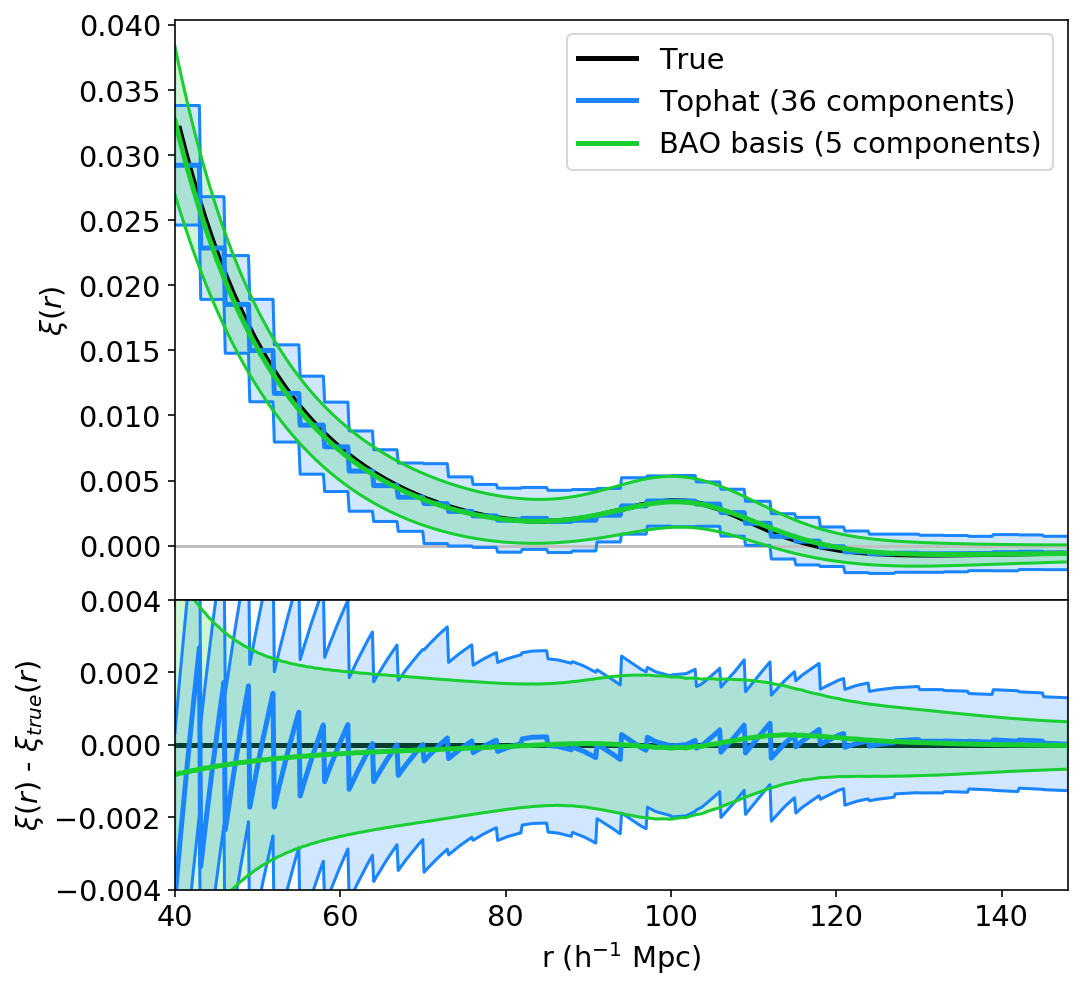

In [37]:
realizations=range(100)
cat_tag = '_L750_n1e-4'
cf_tags = ['_tophat_bw3', f'_baoiter_alpha1.1']
#colors = ['blue']*len(cf_tags)
#colors = ['blue', 'magenta']
colors = [ctopmany, cbao]
labels = ['Tophat (36 components)', 'BAO basis (5 components)']
plot_baoiter_converged(cat_tag, cf_tags, colors=colors, labels=labels, realizations=realizations, errlim=[-0.004, 0.004])

Found 100 converged BAO cfs (0 not converged)
(2, 1000)
rmse: True
plotting
0.0010186 100000.0


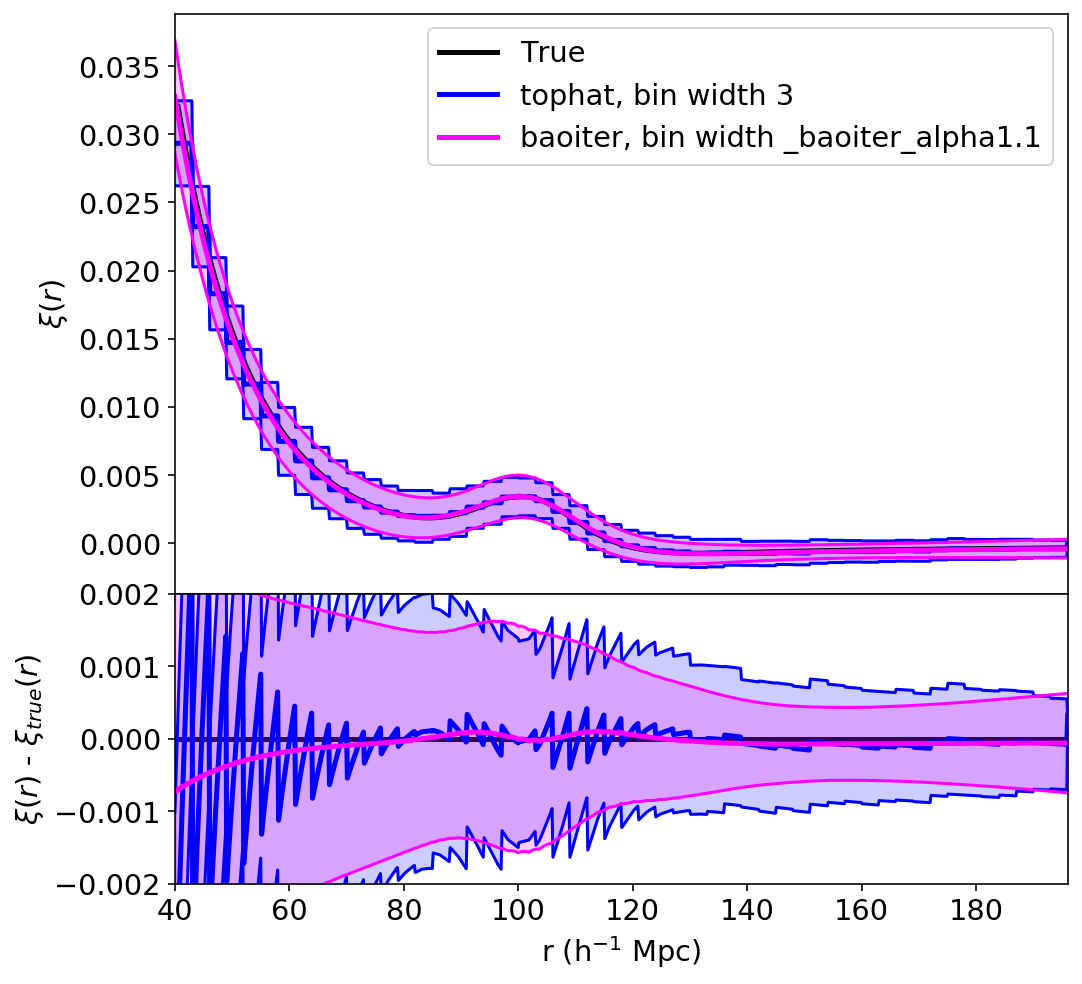

In [23]:
realizations=range(100)
cat_tag = '_L750_n3e-4'
cf_tags = ['_tophat_bw3', f'_baoiter_alpha1.1']
#colors = ['blue']*len(cf_tags)
colors = ['blue', 'magenta']
plot_baoiter_converged(cat_tag, cf_tags, colors=colors, realizations=realizations, errlim=[-0.002, 0.002])

Found 100 converged BAO cfs (0 not converged)
(2, 1000)
rmse: True
plotting
0.0010186 100000.0


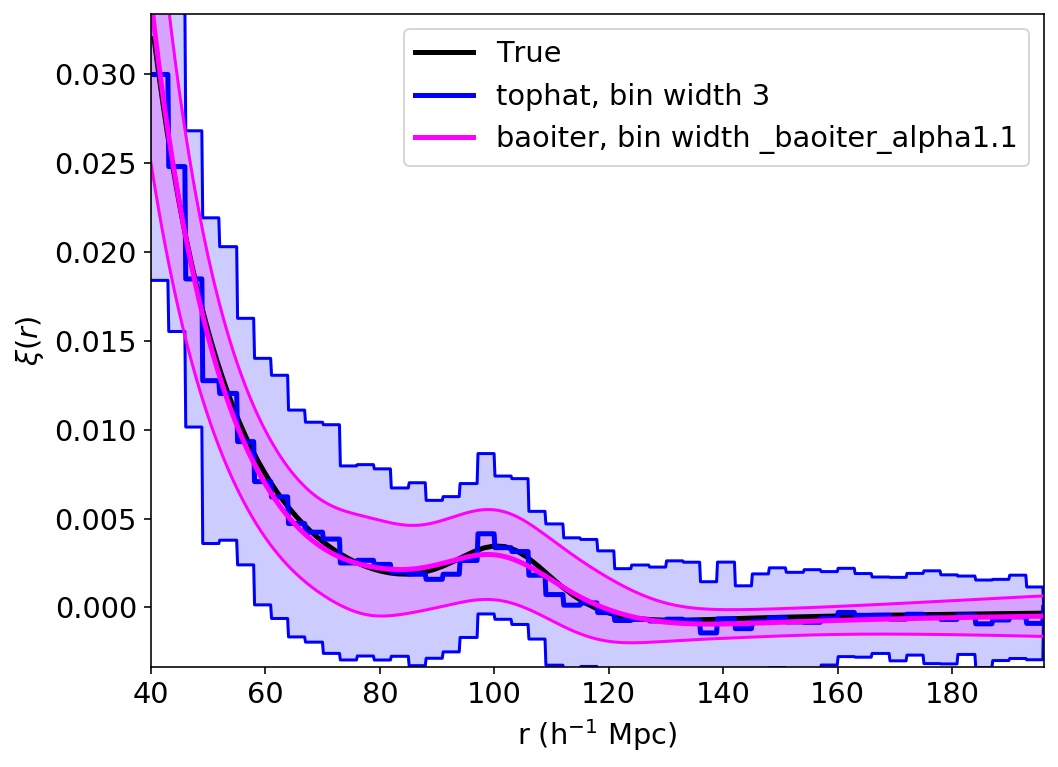

In [27]:
realizations=range(100)
cat_tag = '_L750_n3e-5'
cf_tags = ['_tophat_bw3', f'_baoiter_alpha1.1']
#colors = ['blue']*len(cf_tags)
colors = ['blue', 'magenta']
plot_baoiter_converged(cat_tag, cf_tags, colors=colors, realizations=realizations)

[-25.86968489   7.6836402   -4.28424104   1.22277854 -12.94534706]
[-64.48493313  12.04011237  -5.33956462   1.84859244   6.12691874]
[-68.05747504  12.55219667  -5.47786516   1.99082143  -2.22534287]
[-70.66314211  12.81167979  -5.53578467   2.00674463   1.25423327]
[-69.77463991  12.732667    -5.51957543   2.00869904  -0.63917888]
[-70.41288939  12.79426231  -5.53301577   2.01109262   0.34654558]
[-70.17868163  12.77307356  -5.52858788   2.01131401  -0.20145371]
(7, 1000)
rmse: True
plotting
0.0010186 100000.0


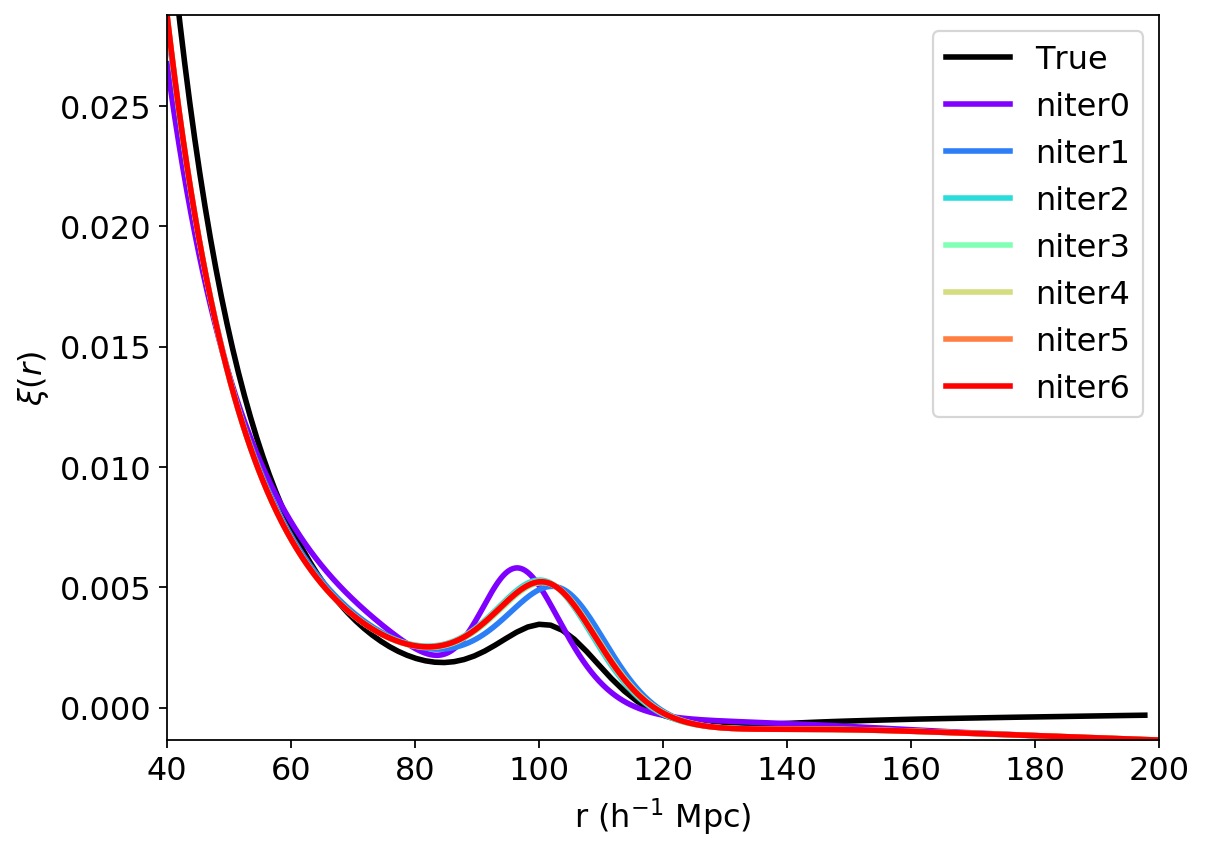

In [117]:
cat_tag = '_L750_n3e-4'
niters = 7
cf_tags = [f'_baoiter_alpha1.1_niter{niter}' for niter in range(niters)]
#colors = ['blue']*len(cf_tags)
colors = plt.cm.rainbow(np.linspace(0, 1, len(cf_tags)))
labels = [f'niter{niter}' for niter in range(niters)]*len(cf_tags)
plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels, Nrealizations=1)

[ 68.41755164 -15.35807663   6.76424895   0.87114363 -12.23677438]
[ 43.44429351 -12.30683646   5.99016219   1.45861989   7.90138704]
[ 37.55874017 -11.69476973   5.84641266   1.50662327  -5.31068982]
[ 34.96603209 -11.34873708   5.75560539   1.59362288   4.73293128]
[ 34.92613812 -11.382564     5.76845836   1.56136194  -3.80714224]
[ 33.2444795  -11.15629617   5.7088224    1.61934636   3.45624839]
[ 33.77671563 -11.24509084   5.73395484   1.58621204  -2.8951083 ]
[ 32.48336267 -11.07193648   5.68845371   1.63017637   2.64163438]
[ 33.11193226 -11.16565785   5.71407588   1.6006175   -2.27611683]
[ 32.13799032 -11.0344212    5.67947318   1.63440235   2.08610418]
[ 32.71573501 -11.11784529   5.70204743   1.60959395  -1.82253901]
[ 31.93490792 -11.01353225   5.6746371    1.63593433   1.64699825]
[ 32.45657417 -11.08634246   5.69407652   1.6156553   -1.4337041 ]
[ 31.86773956 -11.00677139   5.67305399   1.63624515   1.30716121]
[ 32.26615903 -11.06283587   5.6880969    1.62037682  -1.14803

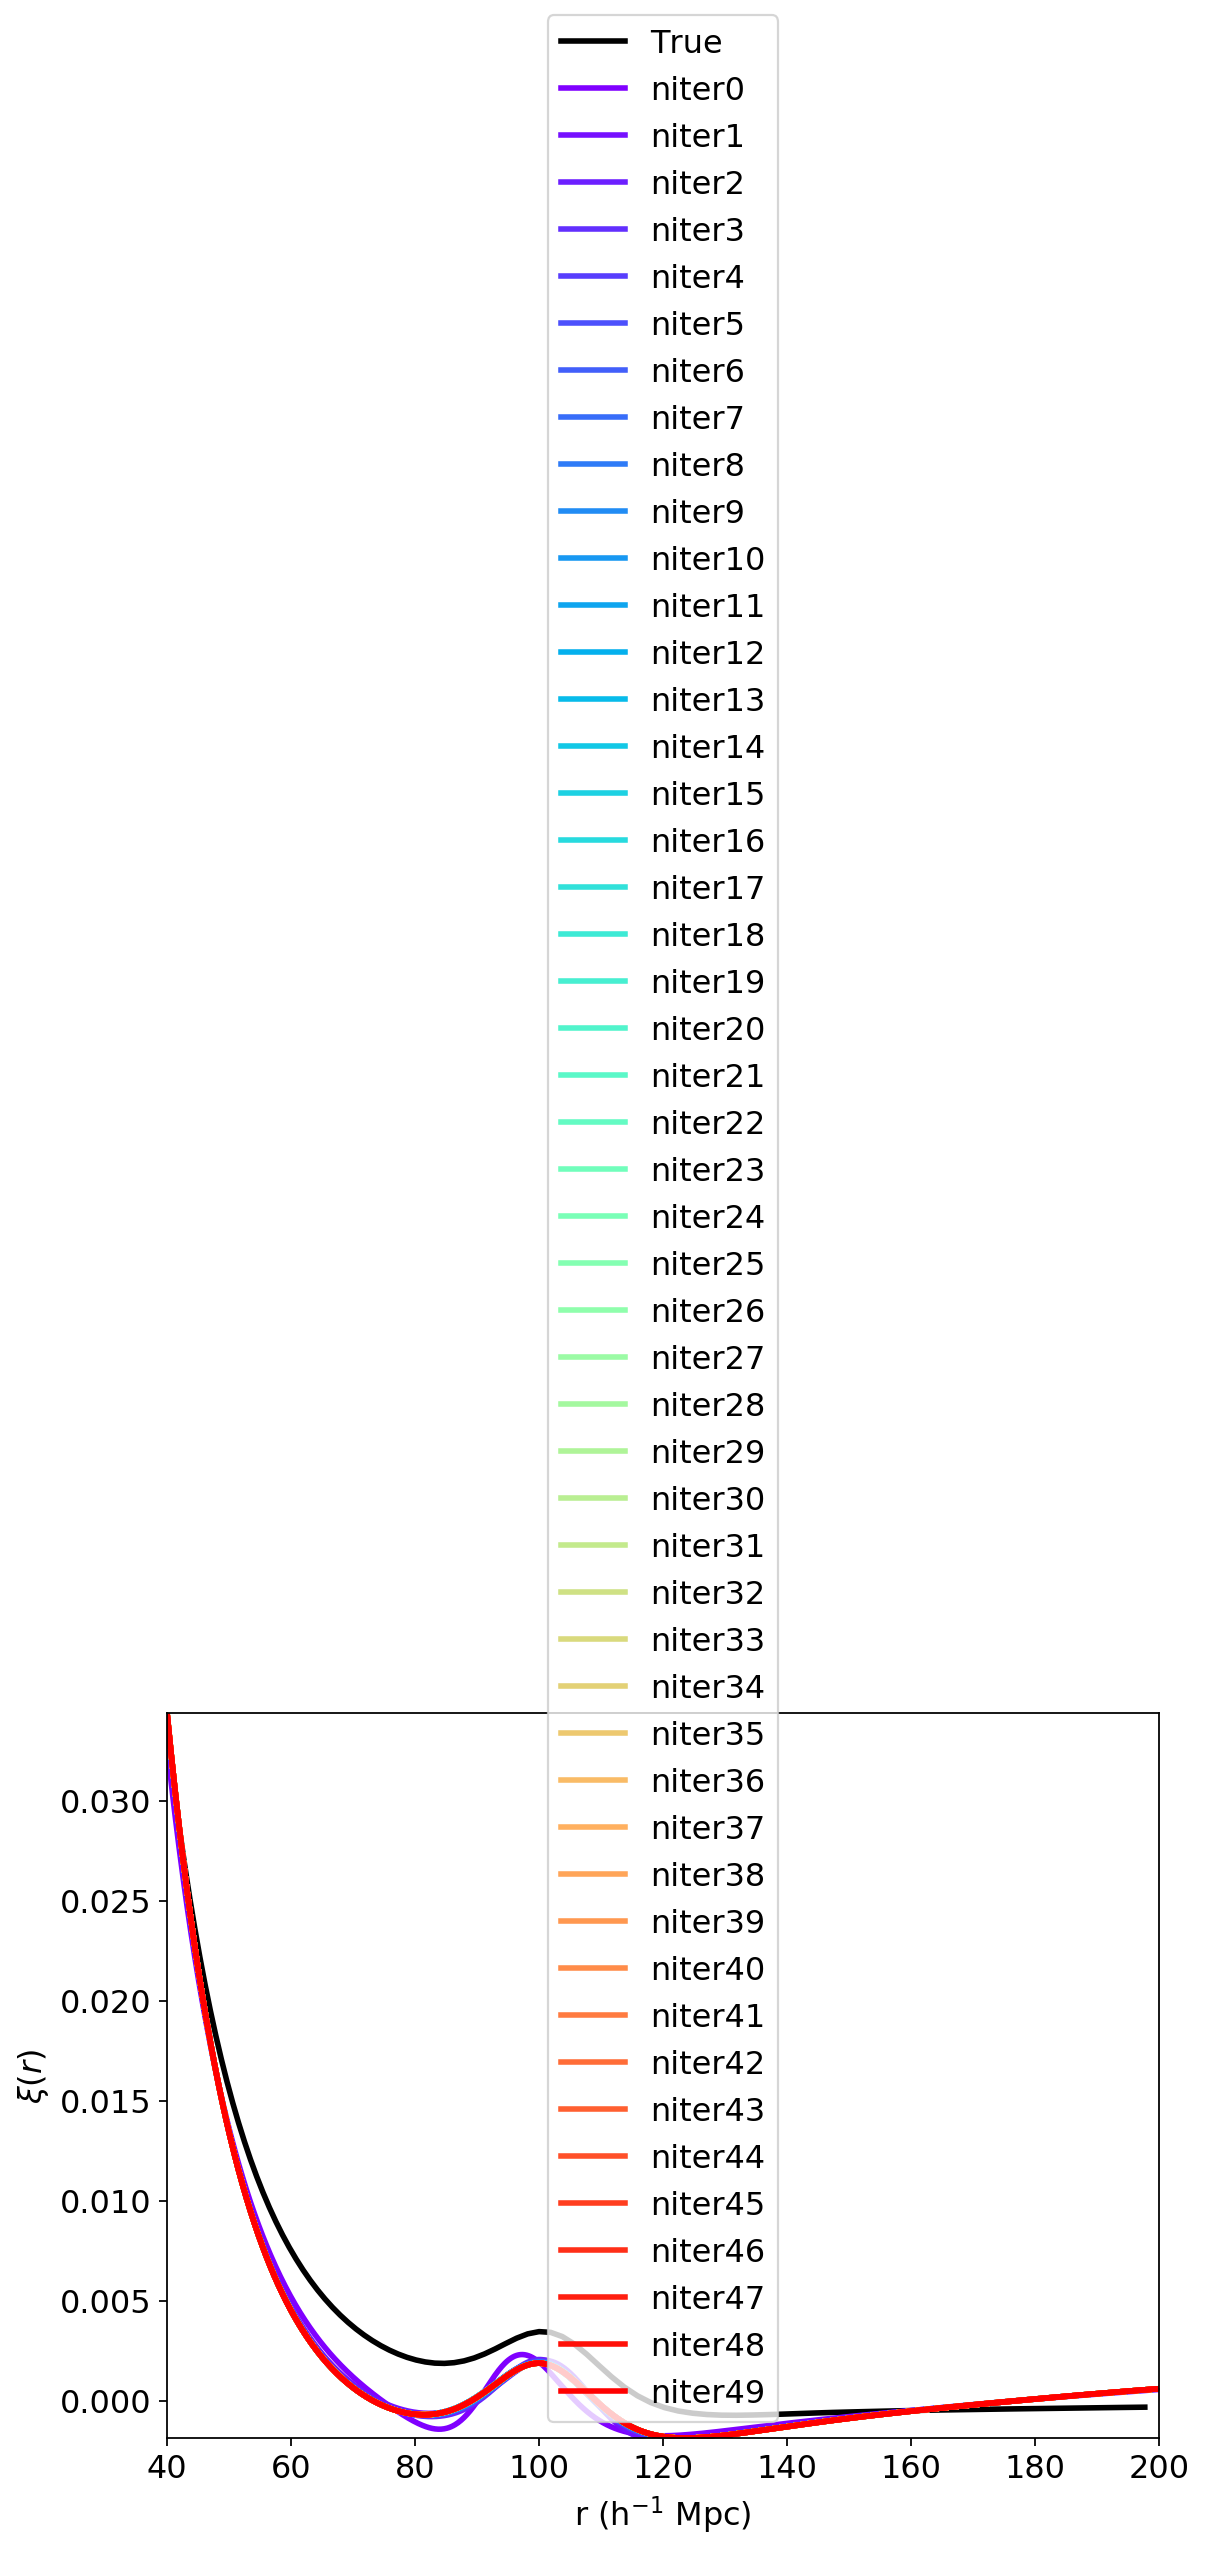

In [132]:
realizations = [15]
cat_tag = '_L750_n3e-4'
niters = 50
cf_tags = [f'_baoiter_alpha1.1_niter{niter}' for niter in range(niters)]
#colors = ['blue']*len(cf_tags)
colors = plt.cm.rainbow(np.linspace(0, 1, len(cf_tags)))
labels = [f'niter{niter}' for niter in range(niters)]*len(cf_tags)
plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels, realizations=realizations)

[169.11744526 -33.70359524  13.99417854  -0.30975444 -11.98989848]
[123.59068681 -27.94308897  12.50659973   0.91432709   5.73483481]
[123.82364428 -28.24817527  12.61299164   0.68098914  -7.11842691]
[134.60998835 -29.10366888  12.78620974   0.81328804   9.55108516]
[132.62207589 -29.32521368  12.88753496   0.47309461  -9.87000626]
[145.22181888 -30.24770454  13.06583394   0.69574382  11.68187764]
[136.592421   -29.80506574  13.00916965   0.38449323 -10.65793883]
[147.34101686 -30.47768885  13.12222694   0.67106533  12.00177869]
[136.99909791 -29.85368764  13.02141286   0.3758379  -10.71610726]
[147.3452831  -30.478153    13.12234092   0.67101476  12.00237826]
[136.9996207  -29.85375063  13.0214288    0.37582641 -10.71619472]
[147.34542194 -30.47816808  13.12234463   0.67101314  12.00239856]
[136.99964229 -29.85375323  13.02142946   0.37582593 -10.71619833]
[147.34542768 -30.4781687   13.12234478   0.67101307  12.0023994 ]
[136.99964319 -29.85375334  13.02142949   0.37582591 -10.71619

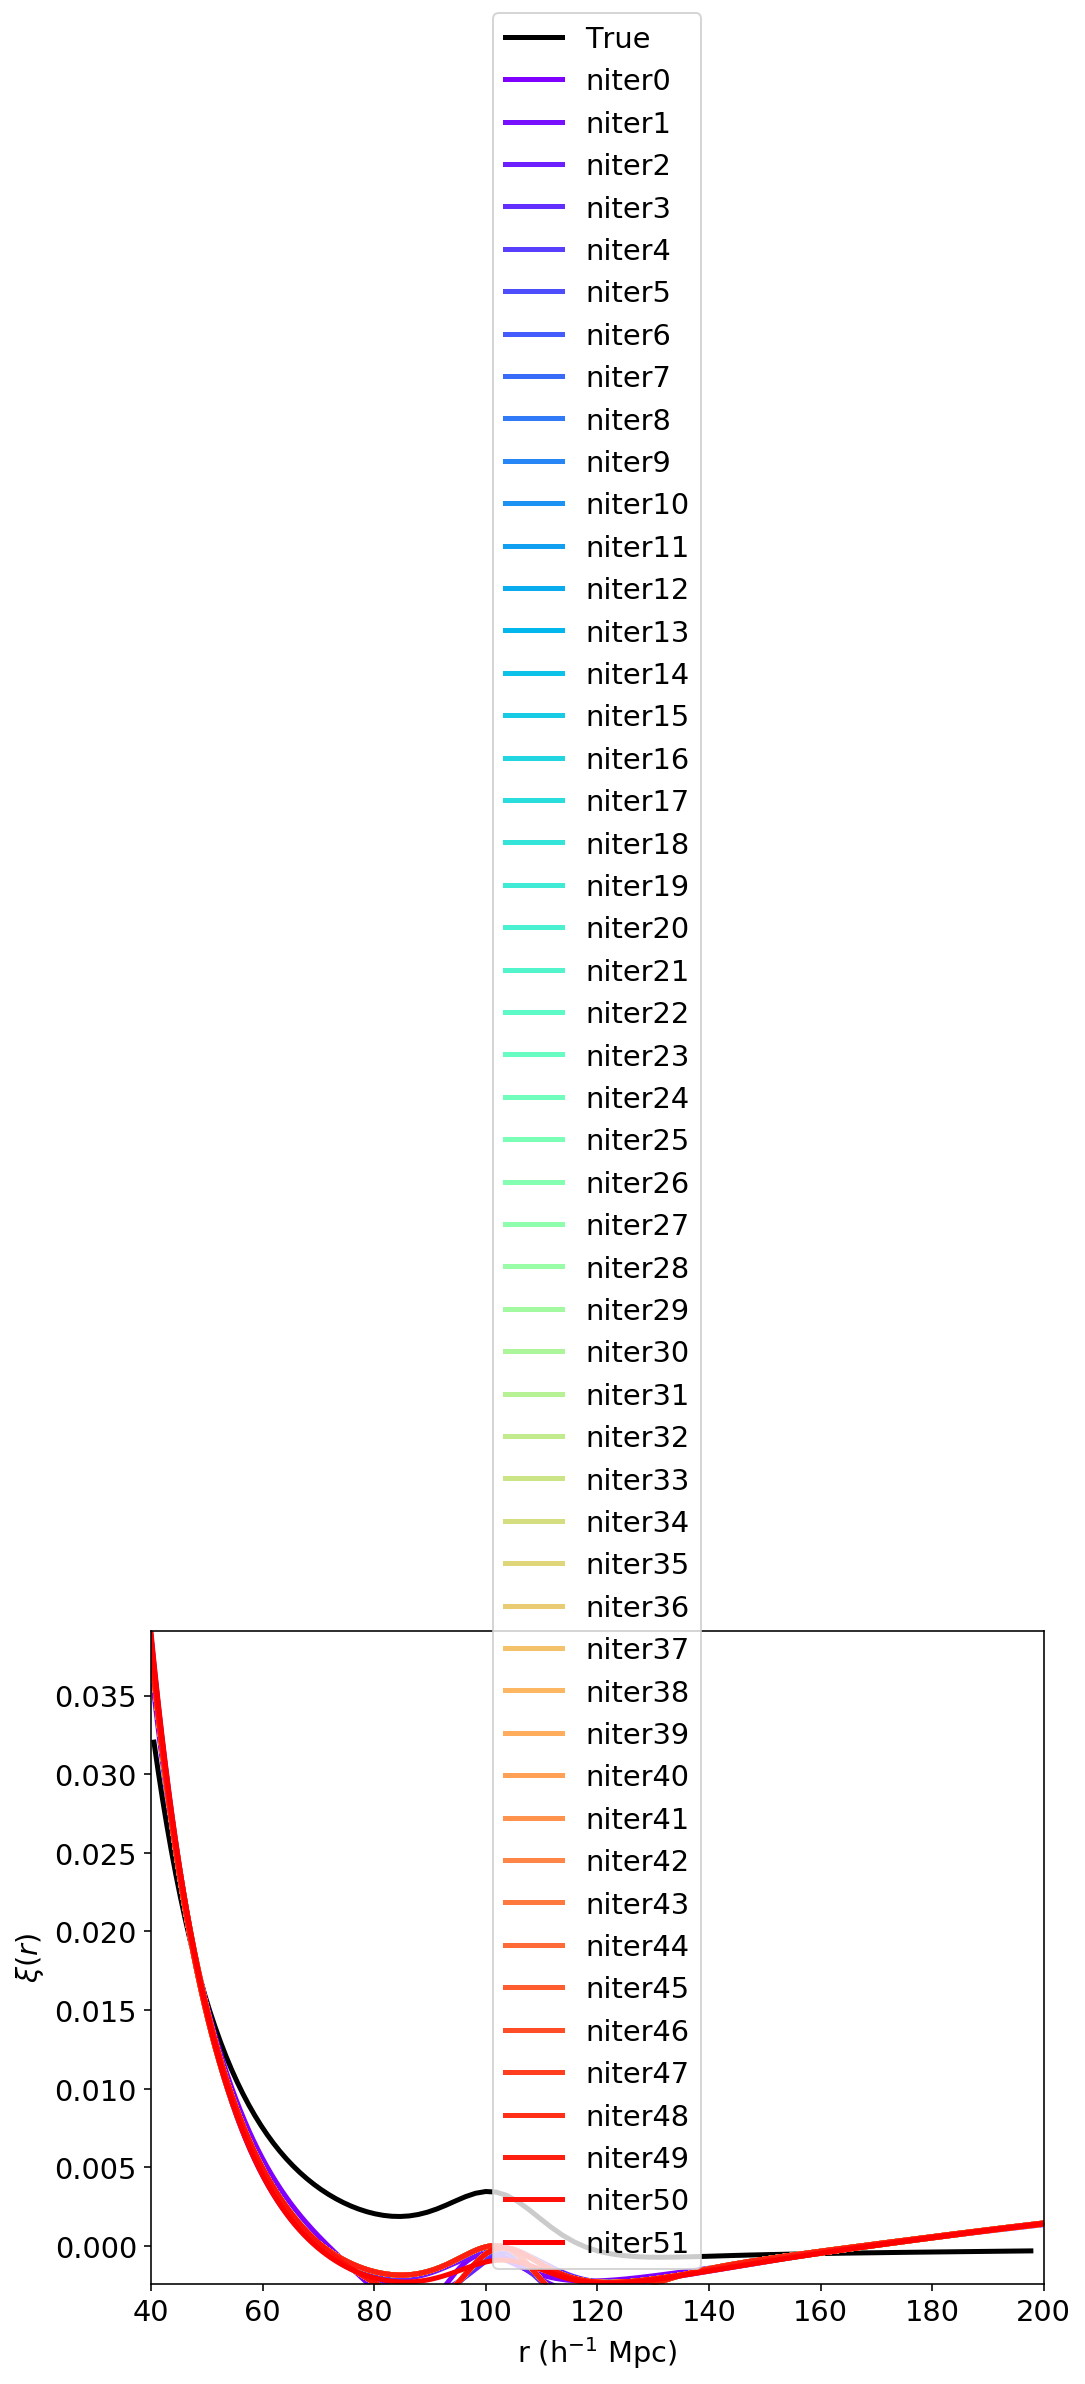

In [20]:
realizations = [2]
cat_tag = '_L750_n1e-4'
niters = 52
cf_tags = [f'_baoiter_alpha1.1_niter{niter}' for niter in range(niters)]
#colors = ['blue']*len(cf_tags)
colors = plt.cm.rainbow(np.linspace(0, 1, len(cf_tags)))
labels = [f'niter{niter}' for niter in range(niters)]*len(cf_tags)
plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels, realizations=realizations)

[-12.43973868   5.32690562  -3.55129356   1.59605086 -11.7232764 ]
[-18.59184086   6.06465562  -3.73709179   1.73113869  10.10018494]
[-28.64502835   7.26023442  -4.03775199   1.93624363  -6.64602245]
[-32.03269187   7.63153186  -4.12502434   1.98586611   6.46329211]
[-31.11847048   7.55177978  -4.1103713    1.98589803  -5.42650802]
[-34.13757877   7.87965447  -4.1868351    2.02787689   5.33544959]
[-32.44254168   7.70804996  -4.14932685   2.01268512  -4.63431945]
[-35.27307579   8.01489322  -4.22068208   2.05167882   4.57106595]
[-33.34762468   7.81318483  -4.17517378   2.02983636  -4.09655027]
[-35.8024534    8.07884006  -4.23687673   2.06337563   4.07641777]
[-33.82115261   7.86858749  -4.18892619   2.03907469  -3.70843099]
[-36.13796409   8.11924376  -4.24711729   2.0706365    3.6827267 ]
[-34.30252663   7.92460589  -4.20269443   2.048313    -3.37973657]
[-36.48330977   8.16010099  -4.25728198   2.07764137   3.3443123 ]
[-34.67292434   7.96698055  -4.21300396   2.05485678  -3.09466

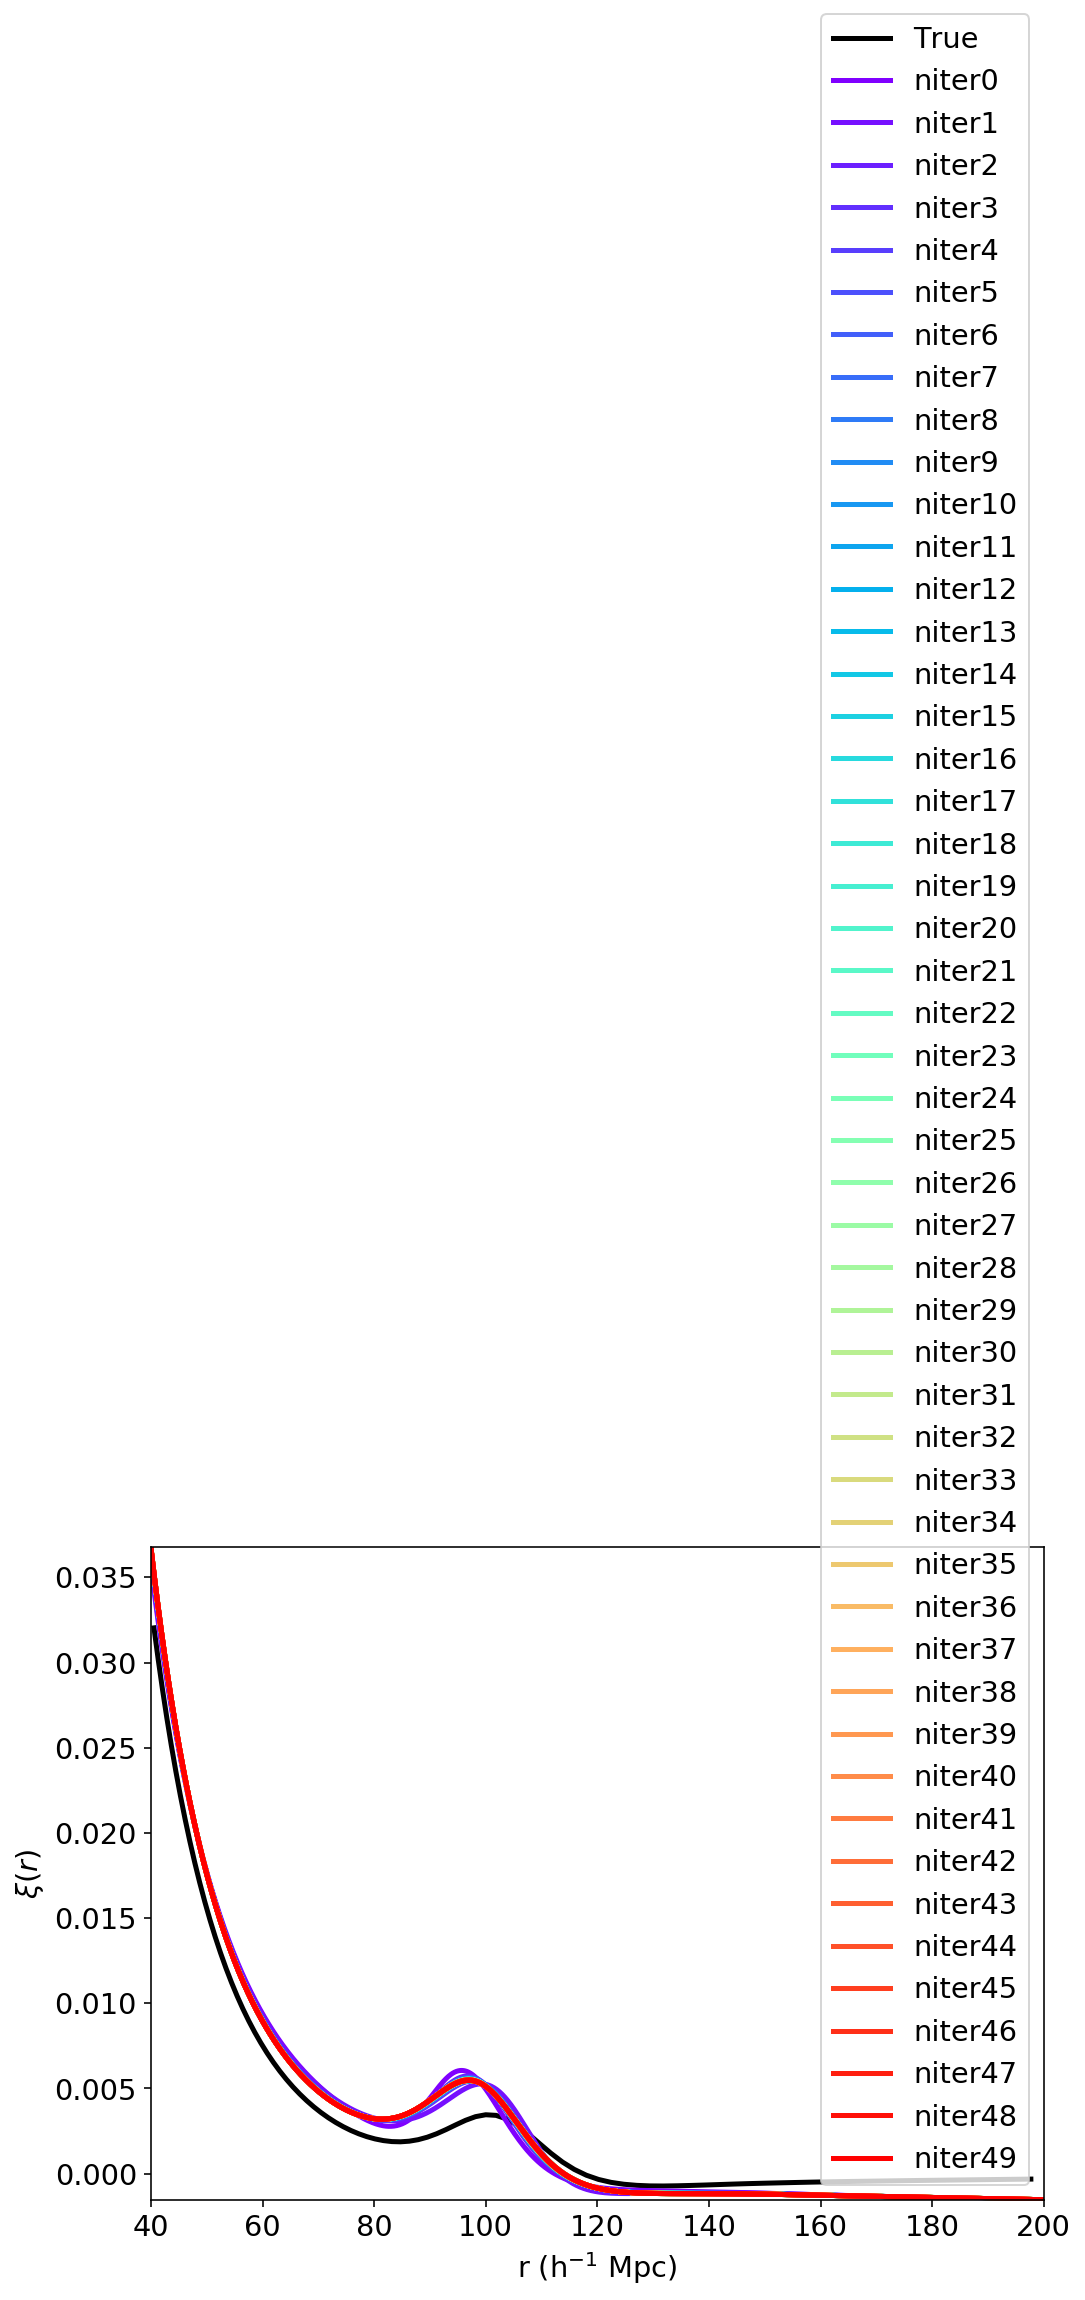

In [16]:
realizations = [84]
cat_tag = '_L750_n1e-4'
niters = 50
cf_tags = [f'_baoiter_alpha1.1_niter{niter}' for niter in range(niters)]
#colors = ['blue']*len(cf_tags)
colors = plt.cm.rainbow(np.linspace(0, 1, len(cf_tags)))
labels = [f'niter{niter}' for niter in range(niters)]*len(cf_tags)
plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels, realizations=realizations)

[-76.14185804  13.73877726  -5.95032924   1.86564941  -0.24676635]
[34.76553613 -3.82455492  0.05406137  1.1382431  -0.53817359]
[132.62207589 -29.32521368  12.88753496   0.47309461  -9.87000626]
[67.82666796 -9.66890931  3.13064152  0.41647684 -0.11167307]
[48.58089783 -6.15576762  1.4366395   0.69055531 -0.05295869]
[-39.23074874   6.53324506  -2.88534072   1.80494688   0.70026959]
[-27.01888433   2.176248     0.51317397   1.79823015  -1.5623556 ]
[-20.79984593   2.0844275    0.25266074   1.44959291  -0.31609927]
[-91.30854376  18.0137624   -8.12153409   2.48499778  -1.44619027]
[ 70.69338936 -13.02067069   5.41046378   1.02296796  -0.28848781]
(1, 1000)
rmse: True
plotting
0.0010186 100000.0


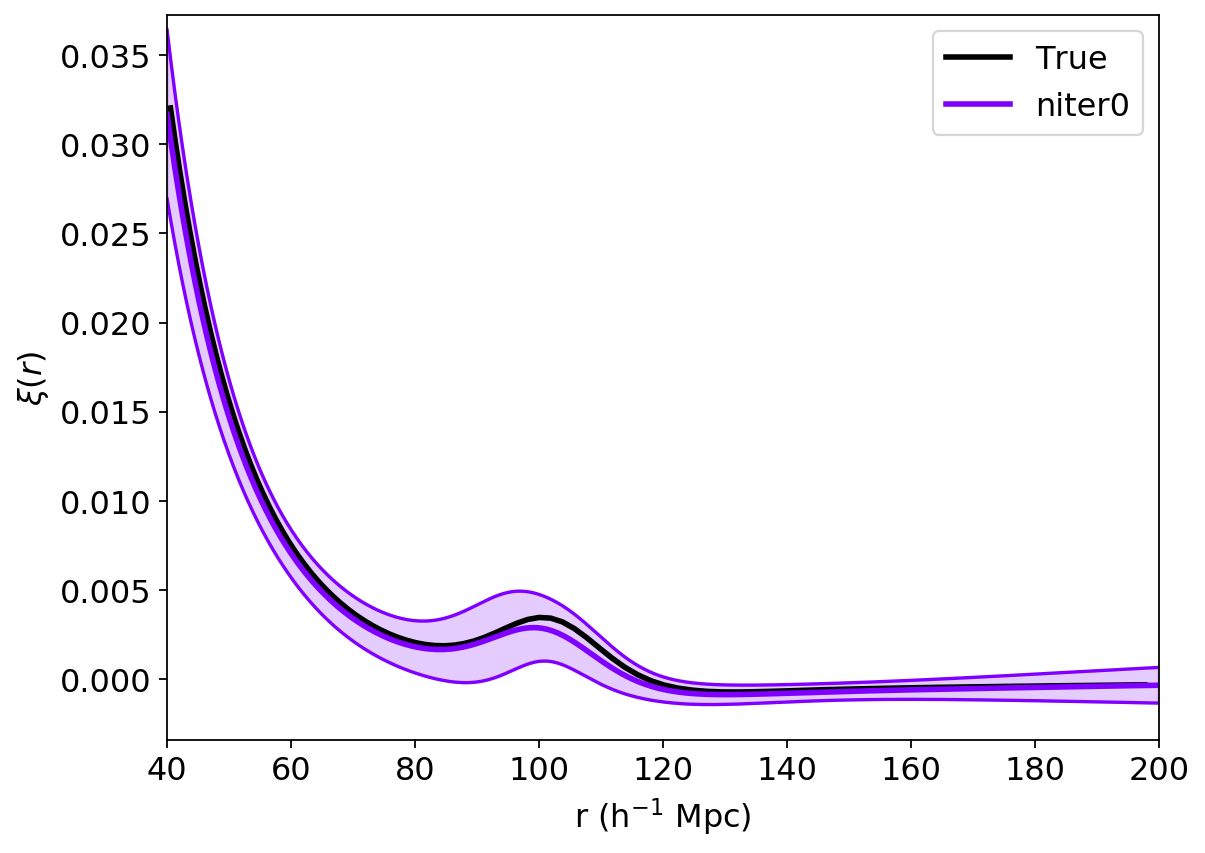

In [32]:
cat_tag = '_L750_n1e-4'
niters = 7
cf_tags = [f'_baoiter_alpha1.1_niter4']
#colors = ['blue']*len(cf_tags)
colors = plt.cm.rainbow(np.linspace(0, 1, len(cf_tags)))
labels = [f'niter{niter}' for niter in range(niters)]*len(cf_tags)
plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels, Nrealizations=10)

In [14]:
#Params used to generate lognormal (Planck)
oc0h2 = 0.11880 # \Omega_c h^2
mnu = 0.00   # \Sigma m_{\nu} total neutrino mass
ns = 0.9667
lnAs = 3.064
ob0h2 = 0.02230 #\Omega_baryon h^2
h0 = 0.6774 # H0/100
w = -1.0
run = 0.0 # running index pf pk

m_ncdm = [] #pass empty list for no massive neutrinos
Omega0_b = ob0h2 / h0**2
Omega0_cdm = oc0h2 / h0**2
cosmo_planck = nbodykit.cosmology.Cosmology(h=h0, Omega0_b=Omega0_b, Omega0_cdm=Omega0_cdm, 
                                            m_ncdm=m_ncdm, n_s=ns, )

In [21]:
cosmo_fid = nbodykit.cosmology.Planck15

In [16]:
# eh pretty close
print(cosmo_planck)
print(nbodykit.cosmology.Planck15)

{'output': 'vTk dTk mPk', 'extra metric transfer functions': 'y', 'h': 0.6774, 'N_ur': 3.046, 'gauge': 'synchronous', 'n_s': 0.9667, 'T_cmb': 2.7255, 'Omega_cdm': 0.2588964265232328, 'Omega_b': 0.048597561544344206, 'N_ncdm': 0, 'P_k_max_h/Mpc': 10.0, 'z_max_pk': 100.0}
{'output': 'vTk dTk mPk', 'extra metric transfer functions': 'y', 'h': 0.6774, 'N_ur': 2.0328, 'gauge': 'synchronous', 'n_s': 0.9667, 'ln10^{10}A_s': 3.064, 'k_pivot': 0.05, 'tau_reio': 0.066, 'T_cmb': 2.7255, 'Omega_cdm': 0.2589, 'Omega_b': 0.0486, 'Omega_k': 0.0, 'N_ncdm': 1, 'm_ncdm': [0.06], 'P_k_max_h/Mpc': 10.0, 'z_max_pk': 100.0}


In [18]:
Omega0_cdm = 0.31
Omega0_b = 0.04814
h0 = 0.676
ns = 0.96

cosmo_b17 = nbodykit.cosmology.Cosmology(h=h0, Omega0_b=Omega0_b, Omega0_cdm=Omega0_cdm, n_s=ns)
print(cosmo_b17)

{'output': 'vTk dTk mPk', 'extra metric transfer functions': 'y', 'h': 0.676, 'N_ur': 2.0328, 'gauge': 'synchronous', 'n_s': 0.96, 'T_cmb': 2.7255, 'Omega_cdm': 0.31, 'Omega_b': 0.04814, 'N_ncdm': 1, 'm_ncdm': [0.06], 'P_k_max_h/Mpc': 10.0, 'z_max_pk': 100.0}


In [22]:
z = 0
alpha = bao_utils.compute_alpha(z, cosmo, cosmo_fid)

Cosmo: r_s: 158.26434744831286 D_A: 0.0 Mpc H: 67.74 km / (Mpc s)
Fiducial: r_s: 158.26434744831286 D_A: 0.0 Mpc H: 67.74 km / (Mpc s)
alpha: 1.0


In [37]:
z = 0
alpha = bao_utils.compute_alpha(z, cosmo_planck, cosmo_b17) #1st is truth, 2nd is fiducial

Cosmo: r_s: 158.26595003520382 D_A: 0.0 Mpc H: 67.74 km / (Mpc s)
Fiducial: r_s: 151.6335957884925 D_A: 0.0 Mpc H: 67.60000000000001 km / (Mpc s)
alpha: 0.9574331182642561


In [20]:
cat_tag = '_L750_n3e-5'
cf_tag = '_baoiter_cosmob17'
calc_alpha(cat_tag, cf_tag, realizations=range(100))

_baoiter_cosmob17
Found 100 converged BAO cfs (0 not converged)
alpha_mean: 0.9774988061552798
alpha_std: 0.09619029326578238


Found 100 converged BAO cfs (0 not converged)
(2, 1000)
rmse: True
plotting
0.0010186 100000.0


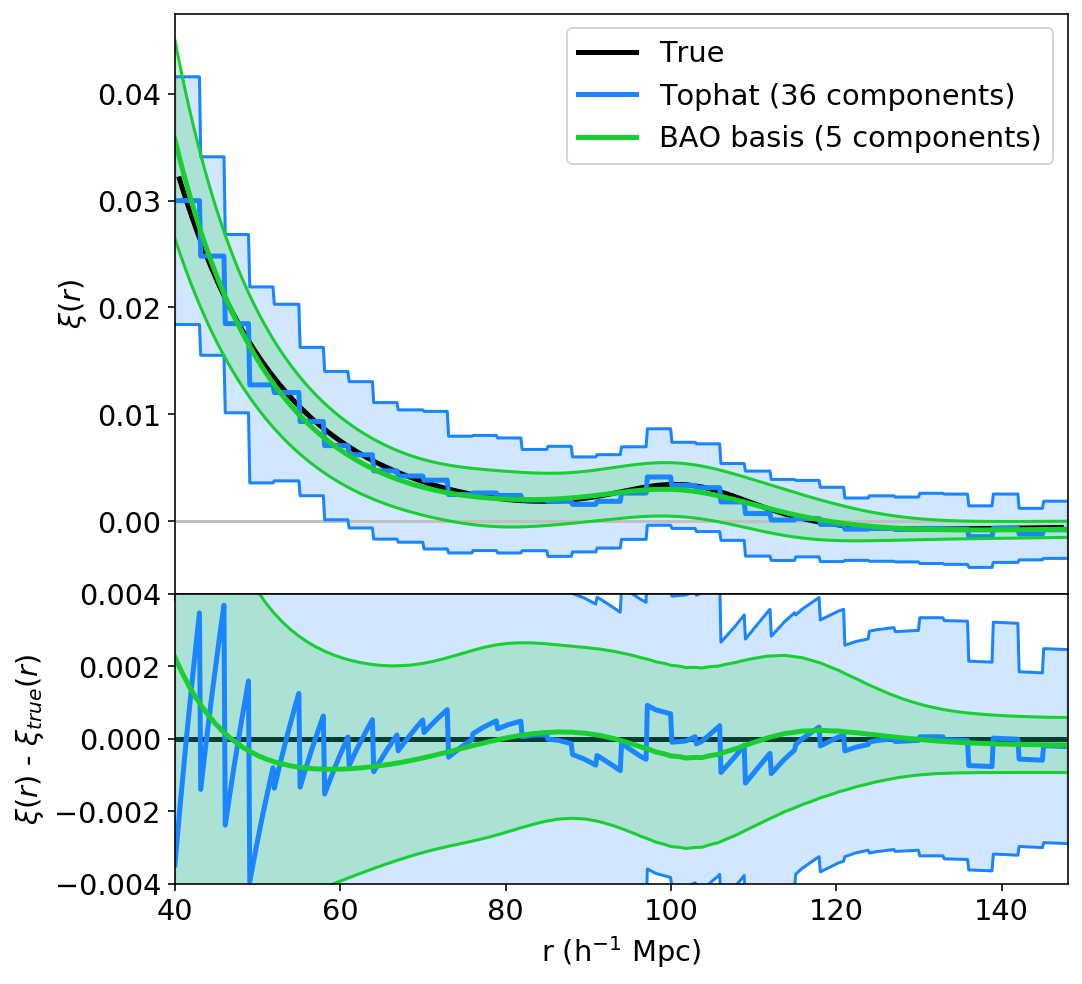

In [19]:
realizations=range(100)
cat_tag = '_L750_n3e-5'
cf_tags = ['_tophat_bw3', f'_baoiter_cosmob17']
#colors = ['blue']*len(cf_tags)
#colors = ['blue', 'magenta']
colors = [ctopmany, cbao]
labels = ['Tophat (36 components)', 'BAO basis (5 components)']
plot_baoiter_converged(cat_tag, cf_tags, colors=colors, labels=labels, realizations=realizations, errlim=[-0.004, 0.004])

In [42]:
cat_tag = '_L750_n1e-4'
cf_tag = '_baoiter_cosmob17'
calc_alpha(cat_tag, cf_tag, realizations=range(100))

_baoiter_cosmob17
alpha_mean: 0.9572297189305252
alpha_std: 0.0315494065293545


Found 88 converged BAO cfs (12 not converged)
(2, 1000)
rmse: True
plotting
0.0010186 100000.0


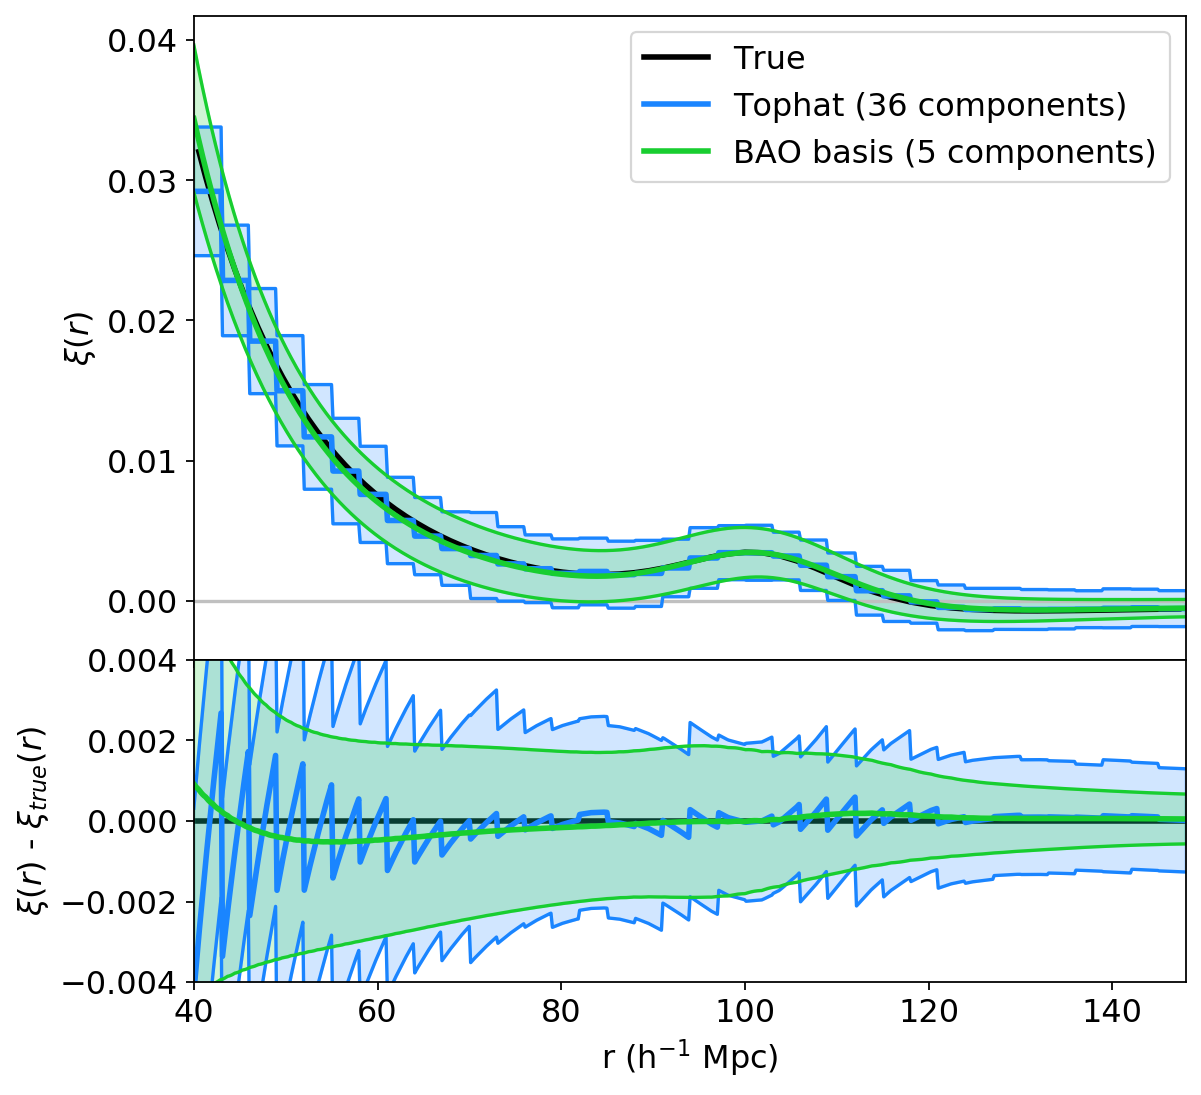

In [43]:
realizations=range(100)
cat_tag = '_L750_n1e-4'
cf_tags = ['_tophat_bw3', f'_baoiter_cosmob17']
#colors = ['blue']*len(cf_tags)
#colors = ['blue', 'magenta']
colors = [ctopmany, cbao]
labels = ['Tophat (36 components)', 'BAO basis (5 components)']
plot_baoiter_converged(cat_tag, cf_tags, colors=colors, labels=labels, realizations=realizations, errlim=[-0.004, 0.004])

In [45]:
cat_tag = '_L750_n3e-4'
cf_tag = '_baoiter_cosmob17'
calc_alpha(cat_tag, cf_tag, realizations=range(100))

_baoiter_cosmob17
alpha_mean: 0.9613083483840006
alpha_std: 0.0274469603661024


Found 96 converged BAO cfs (4 not converged)
(2, 1000)
rmse: True
plotting
0.0010186 100000.0


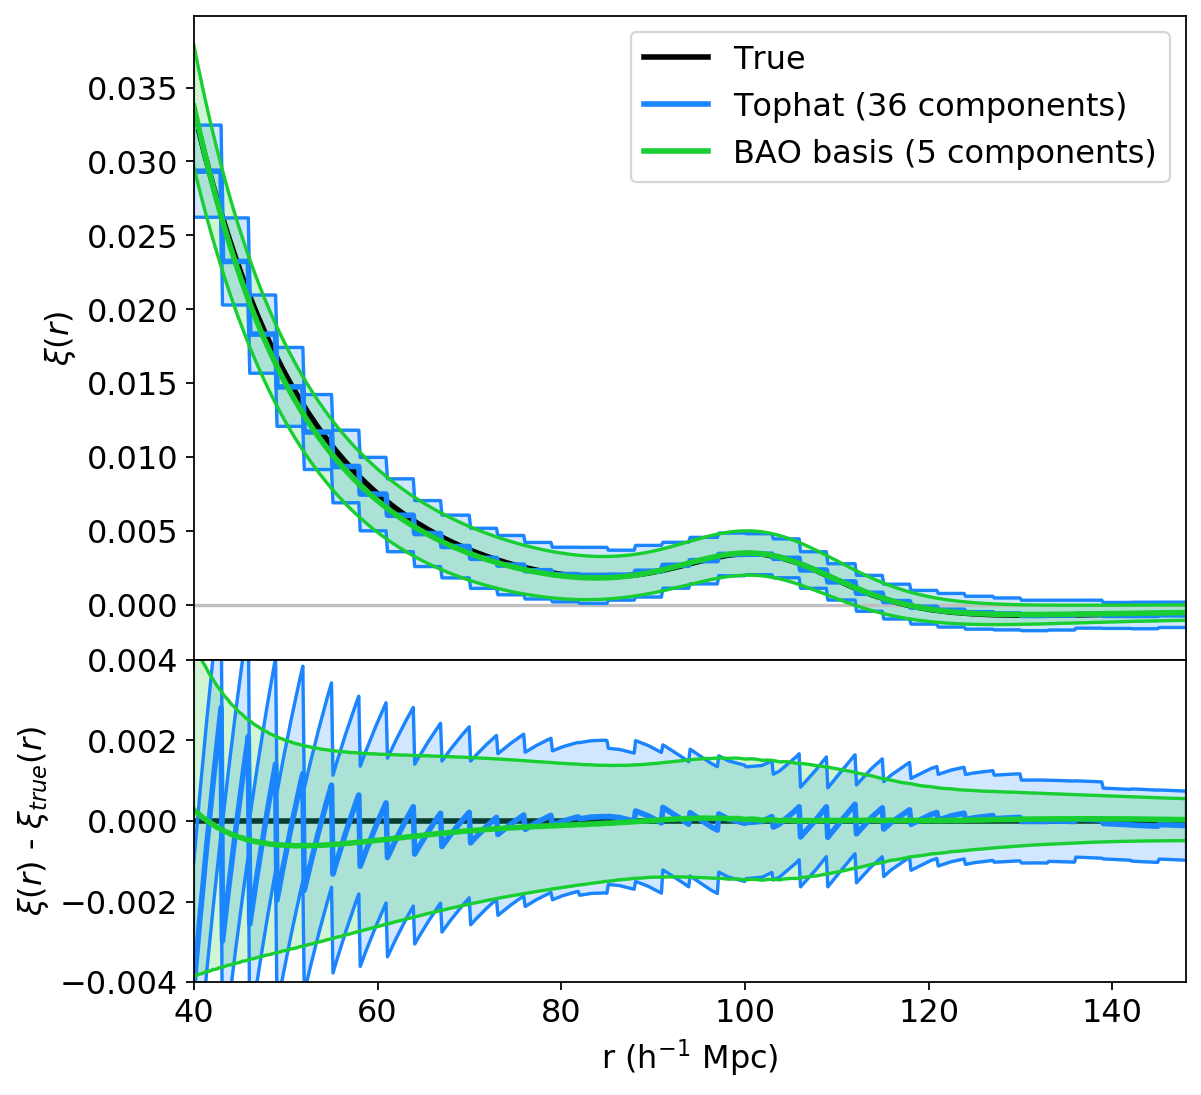

In [44]:
realizations=range(100)
cat_tag = '_L750_n3e-4'
cf_tags = ['_tophat_bw3', f'_baoiter_cosmob17']
#colors = ['blue']*len(cf_tags)
#colors = ['blue', 'magenta']
colors = [ctopmany, cbao]
labels = ['Tophat (36 components)', 'BAO basis (5 components)']
plot_baoiter_converged(cat_tag, cf_tags, colors=colors, labels=labels, realizations=realizations, errlim=[-0.004, 0.004])